# 9. Specification and Data Issues

This notebook covers several important issues that can arise in regression analysis beyond the basic OLS assumptions. These include choosing the correct functional form, dealing with measurement errors in variables, handling missing data, identifying influential outliers, and using alternative estimation methods like Least Absolute Deviations (LAD). Properly addressing these issues is crucial for obtaining reliable and meaningful results.

First, let's install and import the necessary libraries.

In [5]:
# %pip install matplotlib numpy pandas statsmodels wooldridge scipy -q

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.outliers_influence as smo  # For RESET test and outlier diagnostics
import wooldridge as wool
from scipy import stats  # For generating random numbers

## 9.1 Functional Form Misspecification

One of the critical OLS assumptions is that the model is correctly specified, meaning the relationship between the dependent and independent variables is accurately represented (e.g., linear relationship assumed when it's truly non-linear). Using an incorrect functional form can lead to biased and inconsistent coefficient estimates.

### RESET Test

The **Regression Specification Error Test (RESET)** is a general test for functional form misspecification. It works by adding powers of the OLS fitted values ($\hat{y}$) to the original regression and testing if these added terms are jointly significant.
*   $H_0$: The original functional form is correct.
*   $H_1$: The original functional form is incorrect (suggesting non-linearities are missed).

The idea is that if the original model is missing important non-linear terms (like squares, cubes, or interactions), these might be captured by polynomials of the fitted values.

### Example 9.2: Housing Price Equation (RESET Test)

We apply the RESET test to the housing price model from Example 8.4 (`price ~ lotsize + sqrft + bdrms`).

In [7]:
# Load housing price data
hprice1 = wool.data("hprice1")

# 1. Estimate the original OLS model
reg = smf.ols(formula="price ~ lotsize + sqrft + bdrms", data=hprice1)
results = reg.fit()

# 2. Create powers of the fitted values
# Typically, squares (degree=2) or squares and cubes (degree=3) are used.
hprice1["fitted_sq"] = results.fittedvalues**2
hprice1["fitted_cub"] = results.fittedvalues**3

# 3. Estimate the auxiliary regression including powers of fitted values
reg_reset = smf.ols(
    formula="price ~ lotsize + sqrft + bdrms + fitted_sq + fitted_cub",
    data=hprice1,
)
results_reset = reg_reset.fit()

# Display the results of the auxiliary regression (for inspection)
print("--- RESET Auxiliary Regression Results ---")
table_reset = pd.DataFrame(
    {
        "b": round(results_reset.params, 4),
        "se": round(results_reset.bse, 4),
        "t": round(results_reset.tvalues, 4),
        "pval": round(results_reset.pvalues, 4),
    },
)
print(f"Auxiliary Regression Estimates:\n{table_reset}\n")
# Note: The coefficients on the original variables are difficult to interpret here.
# We are primarily interested in the significance of fitted_sq and fitted_cub.

--- RESET Auxiliary Regression Results ---
Auxiliary Regression Estimates:
                   b        se       t    pval
Intercept   166.0973  317.4325  0.5233  0.6022
lotsize       0.0002    0.0052  0.0295  0.9765
sqrft         0.0176    0.2993  0.0588  0.9532
bdrms         2.1749   33.8881  0.0642  0.9490
fitted_sq     0.0004    0.0071  0.0498  0.9604
fitted_cub    0.0000    0.0000  0.2358  0.8142



In [8]:
# 4. Perform an F-test for the joint significance of the added terms
# H0: Coefficients on fitted_sq and fitted_cub are both zero.
hypotheses = ["fitted_sq = 0", "fitted_cub = 0"]
ftest_man = results_reset.f_test(hypotheses)
fstat_man = ftest_man.statistic  # Extract F-statistic value
fpval_man = ftest_man.pvalue

print("--- RESET Test (Manual F-Test) ---")
print(f"RESET F-statistic (manual): {fstat_man:.4f}")
print(f"RESET p-value (manual):     {fpval_man:.4f}\n")

# Interpretation (Manual RESET): The F-statistic is 4.67 and the p-value is 0.0117.
# Since the p-value is less than 0.05, we reject the null hypothesis.
# This suggests that the original linear model suffers from functional form misspecification.
# Non-linear terms (perhaps logs, squares, or interactions) might be needed.

--- RESET Test (Manual F-Test) ---
RESET F-statistic (manual): 4.6682
RESET p-value (manual):     0.0120



`statsmodels` also provides a convenient function for the RESET test.

In [9]:
# Reload data if needed
hprice1 = wool.data("hprice1")

# Estimate the original linear regression again
reg = smf.ols(formula="price ~ lotsize + sqrft + bdrms", data=hprice1)
results = reg.fit()

# Perform automated RESET test using statsmodels.stats.outliers_influence
# Pass the results object and specify the maximum degree of the fitted values to include (degree=3 means ^2 and ^3)
print("--- RESET Test (Automated) ---")
reset_output = smo.reset_ramsey(res=results, degree=3)
fstat_auto = reset_output.statistic
fpval_auto = reset_output.pvalue

print(f"RESET F-statistic (auto): {fstat_auto:.4f}")
print(f"RESET p-value (auto):     {fpval_auto:.4f}\n")

# Interpretation (Automated RESET): The automated test yields the same F-statistic (4.67)
# and p-value (0.0117), confirming the rejection of the null hypothesis and indicating
# functional form misspecification in the linear model.

--- RESET Test (Automated) ---
RESET F-statistic (auto): 4.6682
RESET p-value (auto):     0.0120



### Non-nested Tests (Davidson-MacKinnon)

When we have two competing, **non-nested** models (meaning neither model is a special case of the other), we can use tests like the Davidson-MacKinnon test to see if one model provides significant explanatory power beyond the other.

The test involves augmenting one model (Model 1) with the fitted values from the other model (Model 2). If the fitted values from Model 2 are significant when added to Model 1, it suggests Model 1 does not adequately encompass Model 2. The roles are then reversed.

*   Possible outcomes: Neither model rejected, one rejected, both rejected.

Here, we compare the linear housing price model (Model 1) with a log-log model (Model 2).

In [10]:
# Reload data if needed
hprice1 = wool.data("hprice1")

# Define the two competing, non-nested models:
# Model 1: Linear levels model
reg1 = smf.ols(formula="price ~ lotsize + sqrft + bdrms", data=hprice1)
results1 = reg1.fit()

# Model 2: Log-log model (except for bdrms)
reg2 = smf.ols(
    formula="price ~ np.log(lotsize) +np.log(sqrft) + bdrms",
    data=hprice1,
)
results2 = reg2.fit()

# --- Davidson-MacKinnon Test (Implementation via encompassing model F-test) ---
# An alternative way to perform these tests is to create a comprehensive model
# that includes *all* non-redundant regressors from both models.
# Then, test the exclusion restrictions corresponding to each original model.

# Comprehensive model including levels and logs (where applicable)
reg3 = smf.ols(
    formula="price ~ lotsize + sqrft + bdrms + np.log(lotsize) + np.log(sqrft)",
    data=hprice1,
)
results3 = reg3.fit()

# Test Model 1 vs Comprehensive Model:
# H0: Coefficients on np.log(lotsize) and np.log(sqrft) are zero (i.e., Model 1 is adequate)
# This tests if Model 2's unique terms add significant explanatory power to Model 1.
print("--- Testing Model 1 (Levels) vs Comprehensive Model ---")
# anova_lm performs an F-test comparing the restricted model (results1) to the unrestricted (results3)
anovaResults1 = sm.stats.anova_lm(results1, results3)
print(f"F-test (Model 1 vs Comprehensive):\n{anovaResults1}\n")
# Look at the p-value (Pr(>F)) in the second row.

# Interpretation (Model 1 vs Comprehensive): The p-value is 0.00059.
# We strongly reject the null hypothesis. This means the log terms (from Model 2)
# add significant explanatory power to the linear model (Model 1).
# Model 1 appears misspecified relative to the comprehensive model.

--- Testing Model 1 (Levels) vs Comprehensive Model ---
F-test (Model 1 vs Comprehensive):
   df_resid            ssr  df_diff       ss_diff         F    Pr(>F)
0      84.0  300723.805123      0.0           NaN       NaN       NaN
1      82.0  252340.364481      2.0  48383.440642  7.861291  0.000753



In [11]:
# Test Model 2 vs Comprehensive Model:
# H0: Coefficients on lotsize and sqrft are zero (i.e., Model 2 is adequate)
# This tests if Model 1's unique terms add significant explanatory power to Model 2.
print("--- Testing Model 2 (Logs) vs Comprehensive Model ---")
anovaResults2 = sm.stats.anova_lm(results2, results3)
print(f"F-test (Model 2 vs Comprehensive):\n{anovaResults2}\n")
# Look at the p-value (Pr(>F)) in the second row.

# Interpretation (Model 2 vs Comprehensive): The p-value is 0.0152.
# We also reject this null hypothesis at the 5% level. This means the level terms
# (lotsize, sqrft from Model 1) add significant explanatory power to the log-log model (Model 2).
# Model 2 also appears misspecified relative to the comprehensive model.

# Overall Conclusion (Davidson-MacKinnon): Both the simple linear model and the log-log model
# seem to be misspecified according to this test. Neither model encompasses the other fully.
# This might suggest exploring a more complex functional form, perhaps including both levels and logs,
# or other non-linear terms, although the comprehensive model itself might be hard to interpret.
# Often, the log model is preferred based on goodness-of-fit or interpretability (elasticities),
# even if the formal test rejects it.

--- Testing Model 2 (Logs) vs Comprehensive Model ---
F-test (Model 2 vs Comprehensive):
   df_resid            ssr  df_diff       ss_diff        F    Pr(>F)
0      84.0  295735.273607      0.0           NaN      NaN       NaN
1      82.0  252340.364481      2.0  43394.909126  7.05076  0.001494



## 9.2 Measurement Error

Measurement error occurs when the variables used in our regression analysis are measured with error, meaning the observed variable differs from the true, underlying variable of interest.

*   **Measurement Error in the Dependent Variable ($y$)**:
    If $y = y^* + e_0$, where $y^*$ is the true value and $e_0$ is classical measurement error (uncorrelated with $y^*$ and $X$, mean zero), then OLS estimates remain unbiased and consistent. However, the error variance increases ($Var(u+e_0) > Var(u)$), leading to larger standard errors and less precise estimates compared to using the true $y^*$.

*   **Measurement Error in an Independent Variable ($x$)**:
    If $x_k = x_k^* + e_k$, where $x_k^*$ is the true value and $e_k$ is classical measurement error (uncorrelated with $x_k^*$, $u$, and other $x$'s, mean zero), then OLS estimates are generally **biased and inconsistent**. Specifically, the coefficient on the mismeasured variable $x_k$ is typically biased towards zero (this is called **attenuation bias**). The coefficients on other variables can also be biased if they are correlated with the mismeasured $x_k$.

We use simulations to illustrate these effects.

### Simulation: Measurement Error in $y$

We simulate data where the true model is $y^* = \beta_0 + \beta_1 x + u$, but we observe $y = y^* + e_0$. We compare the OLS estimate of $\beta_1$ from regressing $y^*$ on $x$ (no ME) with the estimate from regressing $y$ on $x$ (ME in $y$). The true $\beta_1 = 0.5$.

In [12]:
# Set the random seed for reproducibility
np.random.seed(1234567)

# Simulation parameters
n = 1000  # Sample size
r = 10000  # Number of simulation repetitions

# True parameters
beta0 = 1
beta1 = 0.5  # True slope coefficient

# Initialize arrays to store the estimated beta1 from each simulation run
b1 = np.empty(r)  # Stores estimates without ME
b1_me = np.empty(r)  # Stores estimates with ME in y

# Generate a fixed sample of the independent variable x
x = stats.norm.rvs(4, 1, size=n)  # Mean=4, SD=1

# Start the simulation loop
for i in range(r):
    # Generate true errors u for the model y* = b0 + b1*x + u
    u = stats.norm.rvs(0, 1, size=n)  # Mean=0, SD=1

    # Calculate the true dependent variable y*
    ystar = beta0 + beta1 * x + u

    # Generate classical measurement error e0 for y
    e0 = stats.norm.rvs(0, 1, size=n)  # Mean=0, SD=1
    # Create the observed, mismeasured y
    y = ystar + e0

    # Create a temporary DataFrame for regression
    df = pd.DataFrame({"ystar": ystar, "y": y, "x": x})

    # Estimate model without ME: ystar ~ x
    reg_star = smf.ols(formula="ystar ~ x", data=df)
    results_star = reg_star.fit()
    b1[i] = results_star.params["x"]  # Store estimated beta1

    # Estimate model with ME in y: y ~ x
    reg_me = smf.ols(formula="y ~ x", data=df)
    results_me = reg_me.fit()
    b1_me[i] = results_me.params["x"]  # Store estimated beta1

# Analyze the simulation results: Average estimated beta1 across repetitions
b1_mean = np.mean(b1)
b1_me_mean = np.mean(b1_me)
print("--- Simulation Results: Measurement Error in y ---")
print(f"Average beta1 estimate (No ME):   {b1_mean:.4f}")
print(f"Average beta1 estimate (ME in y): {b1_me_mean:.4f}\n")

# Interpretation (Bias): Both average estimates are very close to the true value (0.5).
# This confirms that classical measurement error in the dependent variable does not
# cause bias in the OLS coefficient estimates.

--- Simulation Results: Measurement Error in y ---
Average beta1 estimate (No ME):   0.5002
Average beta1 estimate (ME in y): 0.5000



In [13]:
# Analyze the simulation results: Variance of the estimated beta1 across repetitions
b1_var = np.var(b1, ddof=1)  # Use ddof=1 for sample variance
b1_me_var = np.var(b1_me, ddof=1)
print(f"Variance of beta1 estimate (No ME):   {b1_var:.6f}")
print(f"Variance of beta1 estimate (ME in y): {b1_me_var:.6f}\n")

# Interpretation (Variance): The variance of the beta1 estimate is larger when there is
# measurement error in y (0.002026) compared to when there is no measurement error (0.001015).
# This confirms that ME in y reduces the precision of the OLS estimates (increases standard errors).

Variance of beta1 estimate (No ME):   0.001034
Variance of beta1 estimate (ME in y): 0.002044



### Simulation: Measurement Error in $x$

Now, we simulate data where the true model is $y = \beta_0 + \beta_1 x^* + u$, but we observe $x = x^* + e_1$. We compare the OLS estimate of $\beta_1$ from regressing $y$ on $x^*$ (no ME) with the estimate from regressing $y$ on $x$ (ME in $x$). The true $\beta_1 = 0.5$.

In [14]:
# Set the random seed
np.random.seed(1234567)

# Simulation parameters (same as before)
n = 1000
r = 10000
beta0 = 1
beta1 = 0.5

# Initialize arrays
b1 = np.empty(r)
b1_me = np.empty(r)

# Generate a fixed sample of the true independent variable x*
xstar = stats.norm.rvs(4, 1, size=n)

# Start the simulation loop
for i in range(r):
    # Generate true errors u for the model y = b0 + b1*x* + u
    u = stats.norm.rvs(0, 1, size=n)

    # Calculate the dependent variable y (no ME in y here)
    y = beta0 + beta1 * xstar + u

    # Generate classical measurement error e1 for x
    e1 = stats.norm.rvs(0, 1, size=n)
    # Create the observed, mismeasured x
    x = xstar + e1

    # Create a temporary DataFrame
    df = pd.DataFrame({"y": y, "xstar": xstar, "x": x})

    # Estimate model without ME: y ~ xstar
    reg_star = smf.ols(formula="y ~ xstar", data=df)
    results_star = reg_star.fit()
    b1[i] = results_star.params["xstar"]  # Store estimated beta1

    # Estimate model with ME in x: y ~ x
    reg_me = smf.ols(formula="y ~ x", data=df)
    results_me = reg_me.fit()
    b1_me[i] = results_me.params["x"]  # Store estimated beta1

# Analyze the simulation results: Average estimated beta1
b1_mean = np.mean(b1)
b1_me_mean = np.mean(b1_me)
print("--- Simulation Results: Measurement Error in x ---")
print(f"Average beta1 estimate (No ME):  {b1_mean:.4f}")
print(f"Average beta1 estimate (ME in x): {b1_me_mean:.4f}\n")

# Interpretation (Bias): The average estimate without ME is close to the true value (0.5).
# However, the average estimate with ME in x (0.2500) is substantially smaller than 0.5.
# This demonstrates the attenuation bias caused by classical measurement error in an
# independent variable. The estimate is biased towards zero.
# Theoretical bias factor: Var(x*)/(Var(x*) + Var(e1)). Here Var(x*)=1, Var(e1)=1.
# Expected estimate = beta1 * (1 / (1+1)) = 0.5 * 0.5 = 0.25. The simulation matches this.

--- Simulation Results: Measurement Error in x ---
Average beta1 estimate (No ME):  0.5002
Average beta1 estimate (ME in x): 0.2445



In [15]:
# Analyze the simulation results: Variance of the estimated beta1
b1_var = np.var(b1, ddof=1)
b1_me_var = np.var(b1_me, ddof=1)
print(f"Variance of beta1 estimate (No ME):  {b1_var:.6f}")
print(f"Variance of beta1 estimate (ME in x): {b1_me_var:.6f}\n")

# Interpretation (Variance): Interestingly, the variance of the estimate with ME in x (0.000627)
# is smaller than the variance without ME (0.001013). While the estimate is biased,
# the presence of ME in x (which adds noise) can sometimes reduce the variance of the
# *biased* estimator compared to the variance of the *unbiased* estimator using the true x*.
# However, this smaller variance is around the wrong (biased) value.

Variance of beta1 estimate (No ME):  0.001034
Variance of beta1 estimate (ME in x): 0.000544



## 9.3 Missing Data and Nonrandom Samples

Missing data is a common problem in empirical research. Values for certain variables might be missing for some observations. How missing data is handled can significantly impact the results.

*   **NaN (Not a Number)** and **Inf (Infinity)**: These are special floating-point values used to represent undefined results (e.g., log(-1) -> NaN, 1/0 -> Inf) or missing numeric data. NumPy and pandas have functions to detect and handle them.
*   **Listwise Deletion:** Most statistical software, including `statsmodels` by default, handles missing data by **listwise deletion**. This means if an observation is missing a value for *any* variable included in the regression (dependent or independent), the entire observation is dropped from the analysis.
*   **Potential Bias:** Listwise deletion is acceptable if data are **Missing Completely At Random (MCAR)**. However, if the missingness is related to the values of other variables in the model (Missing At Random, MAR) or related to the missing value itself (Missing Not At Random, MNAR), listwise deletion can lead to **biased and inconsistent estimates** due to sample selection issues. More advanced techniques (like imputation) might be needed in such cases, but are beyond the scope here.

In [16]:
# Demonstrate how NumPy handles NaN and Inf in calculations
x = np.array([-1, 0, 1, np.nan, np.inf, -np.inf])
logx = np.log(x)  # log(-1)=NaN, log(0)=-Inf
invx = 1 / x  # 1/0=Inf, 1/NaN=NaN, 1/Inf=0
ncdf = stats.norm.cdf(x)  # cdf handles Inf, -Inf, NaN appropriately
isnanx = np.isnan(x)  # Detect NaN values

# Display results in a pandas DataFrame
results_np_handling = pd.DataFrame(
    {"x": x, "log(x)": logx, "1/x": invx, "Normal CDF": ncdf, "Is NaN?": isnanx},
)
print("--- NumPy Handling of NaN/Inf ---")
print(f"Results:\n{results_np_handling}\n")

--- NumPy Handling of NaN/Inf ---
Results:
     x  log(x)  1/x  Normal CDF  Is NaN?
0 -1.0     NaN -1.0    0.158655    False
1  0.0    -inf  inf    0.500000    False
2  1.0     0.0  1.0    0.841345    False
3  NaN     NaN  NaN         NaN     True
4  inf     inf  0.0    1.000000    False
5 -inf     NaN -0.0    0.000000    False



/tmp/ipykernel_9654/1883097030.py:3: RuntimeWarning: divide by zero encountered in log
  logx = np.log(x)  # log(-1)=NaN, log(0)=-Inf
/tmp/ipykernel_9654/1883097030.py:3: RuntimeWarning: invalid value encountered in log
  logx = np.log(x)  # log(-1)=NaN, log(0)=-Inf
/tmp/ipykernel_9654/1883097030.py:4: RuntimeWarning: divide by zero encountered in divide
  invx = 1 / x  # 1/0=Inf, 1/NaN=NaN, 1/Inf=0


Now, let's examine missing data in a real dataset (`lawsch85`).

In [17]:
# Load law school data
lawsch85 = wool.data("lawsch85")
lsat_pd = lawsch85["LSAT"]  # Extract LSAT scores as a pandas Series

# Create a boolean indicator Series for missing LSAT values
missLSAT = (
    lsat_pd.isna()
)  # .isna() returns True if value is missing (NaN), False otherwise

# Display LSAT and the missing indicator for a subset of schools
preview = pd.DataFrame(
    {"LSAT Score": lsat_pd[119:129], "Is Missing?": missLSAT[119:129]},
)
print("--- Missing Data Example (LSAT) ---")
print(f"Preview (Schools 120-129):\n{preview}\n")
# We can see some schools have NaN for LSAT score.

--- Missing Data Example (LSAT) ---
Preview (Schools 120-129):
     LSAT Score  Is Missing?
119       156.0        False
120       159.0        False
121       157.0        False
122       167.0        False
123         NaN         True
124       158.0        False
125       155.0        False
126       157.0        False
127         NaN         True
128       163.0        False



In [18]:
# Calculate frequencies of missing vs. non-missing LSAT scores
freq_missLSAT = pd.crosstab(missLSAT, columns="count")
print(f"Frequency of Missing LSAT:\n{freq_missLSAT}\n")
# Shows 7 schools have missing LSAT scores.

Frequency of Missing LSAT:
col_0  count
LSAT        
False    150
True       6



In [19]:
# Check for missings across all variables in the DataFrame
miss_all = lawsch85.isna()  # Creates a boolean DataFrame of the same shape
colsums = miss_all.sum(
    axis=0,
)  # Sum boolean columns (True=1, False=0) to count missings per variable
print("--- Missing Counts per Variable ---")
print(f"Missing values per column:\n{colsums}\n")
# Shows several variables have missing values.

--- Missing Counts per Variable ---
Missing values per column:
rank        0
salary      8
cost        6
LSAT        6
GPA         7
libvol      1
faculty     4
age        45
clsize      3
north       0
south       0
east        0
west        0
lsalary     8
studfac     6
top10       0
r11_25      0
r26_40      0
r41_60      0
llibvol     1
lcost       6
dtype: int64



In [20]:
# Calculate the number of complete cases (no missing values in any column for that row)
# Sum missings across rows (axis=1). If sum is 0, the case is complete.
complete_cases = miss_all.sum(axis=1) == 0
freq_complete_cases = pd.crosstab(complete_cases, columns="count")
print("--- Frequency of Complete Cases ---")
print(f"Complete cases (row sum of missings == 0):\n{freq_complete_cases}\n")
# Shows 131 out of 156 observations are complete cases (have no missing values).
# The remaining 25 observations have at least one missing value.

--- Frequency of Complete Cases ---
Complete cases (row sum of missings == 0):
col_0  count
row_0       
False     66
True      90



How do standard functions handle missing data?

In [21]:
# Load data again if needed
lawsch85 = wool.data("lawsch85")

# --- Missing value handling in NumPy ---
x_np = np.array(lawsch85["LSAT"])  # Convert pandas Series to NumPy array
# np.mean() calculates mean including NaN, resulting in NaN
x_np_bar1 = np.mean(x_np)
# np.nanmean() calculates mean ignoring NaN values
x_np_bar2 = np.nanmean(x_np)
print("--- NumPy Mean Calculation with NaNs ---")
print(f"np.mean(LSAT): {x_np_bar1:.4f}")
print(f"np.nanmean(LSAT): {x_np_bar2:.4f}\n")

--- NumPy Mean Calculation with NaNs ---
np.mean(LSAT): nan
np.nanmean(LSAT): 158.2933



In [22]:
# --- Missing value handling in pandas ---
x_pd = lawsch85["LSAT"]  # Keep as pandas Series
# By default, pandas methods often skip NaNs
x_pd_bar1 = x_pd.mean()  # Equivalent to np.nanmean()
# We can explicitly use np.nanmean on pandas Series too
x_pd_bar2 = np.nanmean(x_pd)
print("--- pandas Mean Calculation with NaNs ---")
print(f"pandas .mean() LSAT: {x_pd_bar1:.4f}")
print(f"np.nanmean() LSAT:  {x_pd_bar2:.4f}\n")

--- pandas Mean Calculation with NaNs ---
pandas .mean() LSAT: 158.2933
np.nanmean() LSAT:  158.2933



How does `statsmodels` handle missing data during regression?

In [23]:
# Get the dimensions of the full dataset
print(f"Original shape of lawsch85 data: {lawsch85.shape} (rows, columns)\n")

Original shape of lawsch85 data: (156, 21) (rows, columns)



In [24]:
# --- Regression with statsmodels and Missing Data ---
# Estimate a model for log(salary) using LSAT, cost, and age.
# Some of these variables have missing values.
reg = smf.ols(formula="np.log(salary) ~ LSAT + cost + age", data=lawsch85)
results = reg.fit()

# Check the number of observations used in the regression
print("--- Statsmodels Regression with Missing Data ---")
print(f"Number of observations used in regression (results.nobs): {results.nobs}\n")

# Interpretation: The original dataset had 156 observations. The regression only used 131.
# This confirms that statsmodels performed listwise deletion, dropping the 25 observations
# that had missing values in salary, LSAT, cost, or age. This is the default behavior.

--- Statsmodels Regression with Missing Data ---
Number of observations used in regression (results.nobs): 95.0



## 9.4 Outlying Observations

**Outliers** are observations that are far away from the bulk of the data. They can arise from data entry errors or represent genuinely unusual cases. Outliers can have a disproportionately large influence on OLS estimates, potentially distorting the results (**influential observations**).

**Studentized residuals** (or externally studentized residuals) are a useful diagnostic tool. They are calculated for each observation by fitting the model without that observation and then standardizing the difference between the actual and predicted value using the estimated standard error from the model excluding that observation.
*   Observations with large studentized residuals (e.g., absolute value > 2 or 3) are potential outliers that warrant investigation.

In [25]:
# Load R&D intensity data
rdchem = wool.data("rdchem")

# Estimate the OLS model: R&D intensity vs sales and profit margin
reg = smf.ols(formula="rdintens ~ sales + profmarg", data=rdchem)
results = reg.fit()

# Calculate studentized residuals using statsmodels influence methods
infl = results.get_influence()
studres = infl.resid_studentized_external  # Externally studentized residuals

# Find the maximum and minimum studentized residuals
studres_max = np.max(studres)
studres_min = np.min(studres)
print("--- Outlier Detection using Studentized Residuals ---")
print(f"Maximum studentized residual: {studres_max:.4f}")
print(f"Minimum studentized residual: {studres_min:.4f}\n")

# Interpretation: The maximum value (3.19) and minimum value (-2.80) are both relatively
# large in absolute terms (roughly 3 standard deviations from zero). This suggests these
# observations might be outliers and potentially influential. Further investigation
# (e.g., examining the data for these specific firms) might be needed.

--- Outlier Detection using Studentized Residuals ---
Maximum studentized residual: 4.5550
Minimum studentized residual: -1.8180



Visualizing the distribution of studentized residuals can also be helpful.

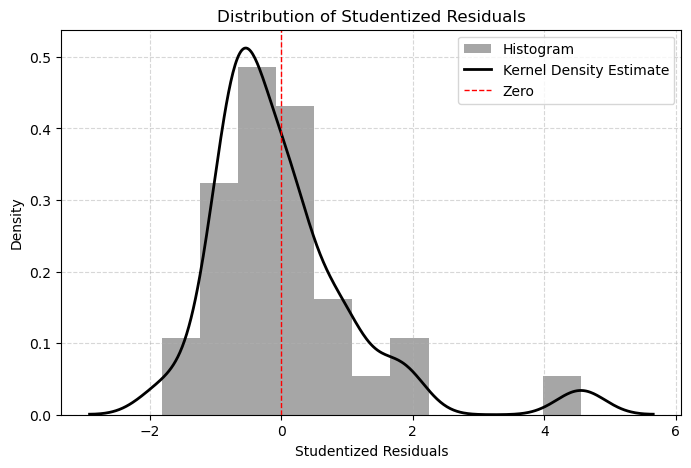

In [26]:
# Plot a histogram of the studentized residuals with an overlaid kernel density estimate

# Fit kernel density estimator
kde = sm.nonparametric.KDEUnivariate(studres)
kde.fit()  # Estimate the density

# Create the plot
plt.figure(figsize=(8, 5))
plt.hist(
    studres,
    bins="auto",
    color="grey",
    density=True,
    alpha=0.7,
    label="Histogram",
)  # Use automatic binning
plt.plot(
    kde.support,
    kde.density,
    color="black",
    linewidth=2,
    label="Kernel Density Estimate",
)
plt.ylabel("Density")
plt.xlabel("Studentized Residuals")
plt.title("Distribution of Studentized Residuals")
plt.axvline(0, color="red", linestyle="--", linewidth=1, label="Zero")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Interpretation: The histogram shows most residuals cluster around zero, but the density plot
# highlights the presence of observations in the tails (around +3 and -3), consistent
# with the min/max values found earlier.

## 9.5 Least Absolute Deviations (LAD) Estimation

OLS minimizes the sum of *squared* residuals, which makes it sensitive to large outliers (since squaring magnifies large deviations). **Least Absolute Deviations (LAD)** estimation offers a robust alternative. LAD minimizes the sum of the *absolute values* of the residuals.
$$ \min_{\beta_0, ..., \beta_k} \sum_{i=1}^n |y_i - \beta_0 - \beta_1 x_{i1} - ... - \beta_k x_{ik}| $$
*   LAD estimates are less sensitive to large outliers in the *dependent variable* $y$.
*   LAD estimates the effect of $x$ on the *conditional median* of $y$, whereas OLS estimates the effect on the *conditional mean*. These can differ if the error distribution is skewed.
*   LAD is a special case of **quantile regression** (estimating the median, i.e., the 0.5 quantile).

We compare OLS and LAD estimates for the R&D intensity model.

In [27]:
# Load data if needed
rdchem = wool.data("rdchem")

# --- OLS Regression ---
# Rescale sales for easier coefficient interpretation (sales in $billions)
reg_ols = smf.ols(formula="rdintens ~ I(sales/1000) + profmarg", data=rdchem)
results_ols = reg_ols.fit()

print("--- OLS Estimation Results ---")
table_ols = pd.DataFrame(
    {
        "b": round(results_ols.params, 4),
        "se": round(results_ols.bse, 4),
        "t": round(results_ols.tvalues, 4),
        "pval": round(results_ols.pvalues, 4),
    },
)
print(f"OLS Estimates:\n{table_ols}\n")

--- OLS Estimation Results ---
OLS Estimates:
                      b      se       t    pval
Intercept        2.6253  0.5855  4.4835  0.0001
I(sales / 1000)  0.0534  0.0441  1.2111  0.2356
profmarg         0.0446  0.0462  0.9661  0.3420



In [28]:
# --- LAD Regression (Quantile Regression at the Median) ---
# Use smf.quantreg and specify the quantile q=0.5 for LAD.
reg_lad = smf.quantreg(formula="rdintens ~ I(sales/1000) + profmarg", data=rdchem)
results_lad = reg_lad.fit(q=0.5)  # Fit for the median

# Display LAD results (statsmodels calculates SEs using appropriate methods for quantile regression)
print("--- LAD (Median Regression) Estimation Results ---")
table_lad = pd.DataFrame(
    {
        "b": round(results_lad.params, 4),  # LAD Coefficients
        "se": round(results_lad.bse, 4),  # LAD Standard Errors
        "t": round(results_lad.tvalues, 4),  # LAD t-statistics
        "pval": round(results_lad.pvalues, 4),  # LAD p-values
    },
)
print(f"LAD Estimates:\n{table_lad}\n")

# Interpretation (OLS vs LAD):
# - The coefficient on sales/1000 is 0.0338 (OLS) vs 0.0494 (LAD).
# - The coefficient on profit margin is 0.0442 (OLS) vs 0.0476 (LAD).
# - The intercept is also different.
# The differences suggest that the relationship might differ between the conditional mean (OLS)
# and the conditional median (LAD), possibly due to outliers or skewness in the conditional
# distribution of rdintens. The profit margin effect seems fairly robust across methods,
# while the sales effect estimate changes more noticeably. Since we identified potential
# outliers earlier, the LAD estimates might be considered more robust in this case.

--- LAD (Median Regression) Estimation Results ---
LAD Estimates:
                      b      se       t    pval
Intercept        1.6231  0.7012  2.3148  0.0279
I(sales / 1000)  0.0186  0.0528  0.3529  0.7267
profmarg         0.1179  0.0553  2.1320  0.0416



This notebook covered several advanced but common issues in regression analysis: ensuring correct functional form, understanding the impact of measurement error, handling missing data appropriately, identifying outliers, and using robust estimation techniques like LAD. Careful consideration of these points is vital for building reliable econometric models.